In [ ]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# Carga de datos

Esta celda crea la función `generate_sensor_data`, que genera un conjunto de datos con:
- Lecturas de sensores aleatorias (entre 0 y 1).
- Valores nulos (`NaN`) introducidos aleatoriamente según una probabilidad.
- Tiempos simulados en una columna `Timestamp`.

In [ ]:
# Function to simulate sensor data
def generate_sensor_data(rows=10000, sensors=10, nan_probability=0.1):
    np.random.seed(42) # For reproducibility

    # Generate random sensor data
    data = np.random.rand(rows, sensors) # Values between 0 and 1

    # Introduce NaN values based on the specified probability
    if nan_probability > 0:
        mask = np.random.choice([1, 0], data.shape, p=[nan_probability, 1 - nan_probability])
        data = np.where(mask == 1, np.nan, data)

    # Create a DataFrame
    df = pd.DataFrame(data, columns=[f"Sensor_{i+1}" for i in range(sensors)])

    # Add a timestamp column
    df['Timestamp'] = pd.date_range(start='2023-01-01', periods=rows, freq='s')

    return df


# Transformación de datos

Esta celda define la función `transform_data`, encargada de aplicar transformaciones y cálculos sobre una fila de datos de sensores.

- **Parámetros:** `args`: Tupla que contiene un índice (`idx`) y una fila (`row`) del conjunto de datos.
- **Transformaciones:** Multiplica las lecturas de los sensores por un factor de 100. Simula un procesamiento complejo con un retraso de 1 segundo por fila.
- **Resultados:** Devuelve una serie con los valores amplificados de los Sensores (`Final_Sensors`), el conteo de valores válidos (`Count`) y los valores mínimo (`Min`) y máximo (`Max`) de la fila procesada.


In [ ]:
# Apply transformations to the sensor data
def transform_data(row):
    t_row = row[:-1] * 100 # Apply mutiply factor

    return pd.Series({
        "Final_Sensors": t_row.tolist(),
        "Count": t_row.count(),
        "Min": t_row.min(),
        "Max": t_row.max(),
    })


# Implementacion de procesamiento secuencial, paralelo y con `apply`

En esta sección se implementan tres enfoques para procesar los datos de sensores:
1. **Procesamiento secuencial:** Procesa las filas del `DataFrame` una por una, midiendo el tiempo total de ejecución.
2. **Procesamiento paralelo:** Divide las filas entre múltiples procesos para acelerar el procesamiento, especialmente en datasets grandes.
3. **Uso de `apply`:** Aprovecha la función vectorizada de pandas para aplicar las transformaciones a todo el conjunto de datos de forma más eficiente.

Cada método se compara en términos de rendimiento y tiempo de ejecución para analizar la eficiencia relativa en diferentes escenarios.


In [ ]:
def process_sequential(data):
    start_time = time.time()

    # Iterate through each row of the DataFrame
    results = [transform_data(row) for  _, row in data.iterrows()]

    end_time = time.time() - start_time
    return end_time


In [ ]:
def process_parallel(data):
    start_time = time.time()

    with Pool(10) as pool:
        results = pool.map(transform_data, [row for _, row in data.iterrows()])

    end_time = time.time() - start_time
    return end_time


La función `benchmark_processing` ejecuta y mide el tiempo de procesamiento de los datos utilizando tres métodos distintos: secuencial, paralelo y con `apply`. Cada método se ejecuta 100 veces para capturar la variabilidad en los tiempos de ejecución.

El propósito es evaluar y comparar el rendimiento de cada enfoque bajo las mismas condiciones. Finalmente, los tiempos resultantes se utilizan para generar un diagrama de caja que muestra la distribución de los tiempos de ejecución, permitiendo identificar cuál método es más eficiente y cómo varía el rendimiento en diferentes ejecuciones.


In [ ]:
def benchmark_processing(data, iterations=100):
    return {
        "Sequential": [
            process_sequential(data)
            for _ in range(iterations)
        ],
        "Parallel": [
            process_parallel(data)
            for _ in range(iterations)
        ],
    }


Se crea una funcion para la visualizacion de resutlados mediante un diagrama de caja

In [ ]:
def plot_benchmark_results(times):
    df = pd.DataFrame(times)
    df.boxplot()
    plt.title("Processing Times for Sequential, Parallel, and Apply")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=0)
    plt.show()


# Análisis de rendimiento

Se usan las funciones creadas para generar los datos, obtener los tiempos de procesamiento y visualizar los resultados

In [ ]:
# Simulate sensor data
sensor_data = generate_sensor_data(rows=10000, sensors=10, nan_probability=0.1)
sensor_data.head()

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Timestamp
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,2023-01-01 00:00:00
1,NaN,0.969910,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,2023-01-01 00:00:01
2,0.611853,0.139494,0.292145,0.366362,NaN,0.785176,0.199674,0.514234,0.592415,0.046450,2023-01-01 00:00:02
3,0.607545,0.170524,0.065052,0.948886,0.965632,NaN,NaN,0.097672,0.684233,0.440152,2023-01-01 00:00:03
4,0.122038,0.495177,0.034389,0.909320,0.258780,0.662522,0.311711,NaN,NaN,0.184854,2023-01-01 00:00:04


In [ ]:
# Run the benchmark
processing_times = benchmark_processing(sensor_data, iterations=10)

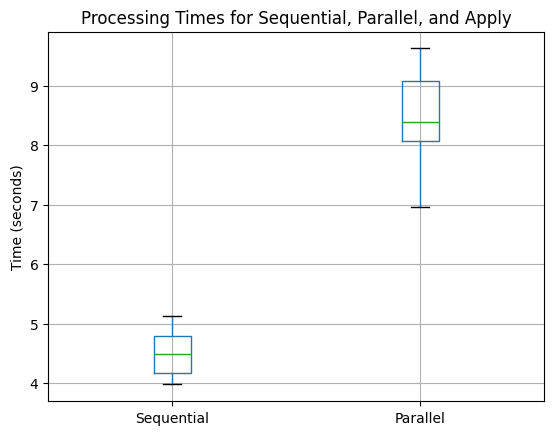

In [ ]:
# Plot the results
plot_benchmark_results(processing_times)

El gráfico muestra los tiempos de ejecución para el procesamiento **secuencial** y **paralelo**. Se observa que el método **secuencial** es más eficiente, mientras que el procesamiento **paralelo** es significativamente más lento. Esto ocurre por las siguientes razones:

1. **Procesamiento secuencial (mejor desempeño):**
   - Realiza las operaciones directamente en el mismo proceso, evitando la sobrecarga asociada con la creación y gestión de múltiples procesos.
   - No requiere serializar ni transferir datos, lo que resulta en un menor tiempo de ejecución, especialmente para operaciones ligeras como las realizadas en esta simulación.

2. **Procesamiento paralelo (peor desempeño):**
   - Introduce un **overhead significativo**, debido a la creación y sincronización de múltiples procesos y la serialización de las filas y transferencia entre procesos.
   - Es menos eficiente para tareas con operaciones rápidas por fila, ya que el costo del paralelismo (overhead) supera los beneficios.

El procesamiento **paralelo** no resulta beneficioso para este tipo de tareas ligeras, donde cada operación es rápida y no lo suficientemente compleja para justificar la sobrecarga del paralelismo. En este caso, el método **secuencial** es la mejor opción.